In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import pandas as pd

import os
#sys.path.insert(0, os.getcwd()) 
import sys
sys.path.append('../')

from Utils import mnist_processor
from Utils import VAE, encoder_setup, decoder_setup
from Utils import run_knn_classifier, run_mlp_classifier, ssl_mlp, ssl_knn
from Utils import plot_orig_recon_imgs
from Utils import init_classifier_dataset, init_hists

In [8]:
# Main parameter
IMG_PER_CLASS=10

In [9]:
x_train, y_train, x_test, y_test=mnist_processor(keras.datasets.mnist)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# PARAMETERS
epochs=30
batch_size=128
ndim=28
latent_dim=128

In [5]:
encoder=encoder_setup(ndim=28, latent_dim=128)
decoder=decoder_setup(latent_dim=128)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(f"VAE_MNIST_{epochs}epochs_{batch_size}batch_50000train_vae_weights")

In [6]:
indices=np.load('digits_random_indices.npy')

In [7]:
x_train_classifier_initial, y_train_classifier_initial, x_test_classifier, y_test_classifier, indices=init_classifier_dataset(None, x_train, y_train, x_test, y_test,
                                                                                                          IMG_PER_CLASS, indices)

[[59331 55030 53857 58015 54368 57186 52305 55402 56397 58510]
 [54210 50477 51033 52317 59958 50652 50855 58056 57740 52078]
 [52224 56493 50381 58409 59855 59675 54326 55525 55559 53390]
 [59408 55881 57227 52432 54767 52022 58379 57856 53241 52751]
 [59407 52457 50835 50844 54769 54007 50889 56331 51270 54447]
 [52947 59064 56898 55349 50959 52452 57128 51254 56036 58790]
 [58770 53230 55512 52100 59907 51507 57514 53220 53331 52957]
 [56028 57365 51429 58099 54364 56017 50943 57286 52008 56346]
 [59636 50996 51160 53653 50762 57513 57411 59838 55741 52980]
 [59058 55347 56618 56166 51185 58616 50845 54592 52770 57545]]
(100, 28, 28, 1)


In [8]:
K=5
MEAN=0
STD=0.5
NOISE_FACTOR=1.0
                                                                                                          
x_train_classifier, y_train_classifier=x_train_classifier_initial.copy(), y_train_classifier_initial.copy()
hist_clf_train_classifier_f1, hist_clf_train_f1, hist_clf_test_f1=init_hists(run_knn_classifier, K,
                                                                            x_train_classifier, y_train_classifier,
                                                                             x_train, y_train.argmax(1),
                                                                               x_test_classifier, y_test_classifier)

"""if not os.path.exists(f"plots/{sampling_method}"):
    os.mkdir(f"plots/{sampling_method}")"""

for i in range(49):
    selected_idx=range(0,IMG_PER_CLASS*10)
    encoded_data = vae.encoder.predict(x_train_classifier[selected_idx], verbose=0)
    encoded_img = encoded_data[-1]
    noise_data = np.random.normal(MEAN, STD, size=encoded_img.shape)
    perturbed_data = NOISE_FACTOR * (noise_data+encoded_img)
    noised_img = vae.decoder.predict(perturbed_data, verbose=0)
    # for j in range(IMG_PER_CLASS*10):
    #     plot_orig_recon_imgs(x_train_classifier[j], noised_img[j], i*10+j, y_train_classifier[j], file_addr=f"plots/{sampling_method}/{i*100+j}")
    
    x_reconst_imgs=noised_img.copy()
    y_reconst_imgs=y_train_classifier[selected_idx].copy()
    
    x_train_classifier = np.concatenate([x_train_classifier, x_reconst_imgs], axis=0)
    y_train_classifier = np.concatenate([y_train_classifier, y_reconst_imgs])
    
    clf_train_classifier_f1, clf_train_f1, clf_test_f1=run_knn_classifier(K, x_train_classifier, y_train_classifier,
                                                 x_train, y_train.argmax(1),
                                                 x_test_classifier, y_test_classifier)
    train_size=x_train_classifier.shape[0]
    print("Train dataset size=", train_size)
    print(f"Classifier Train F1-score {(clf_train_classifier_f1):.3e}")
    print(f"Train F1-score= {(clf_train_f1):.3e}")
    print(f"Test F1-score= {(clf_test_f1):.3e}")
    print("-------------------------------------")
    hist_clf_train_classifier_f1.append(clf_train_classifier_f1)
    hist_clf_train_f1.append(clf_train_f1)
    hist_clf_test_f1.append(clf_test_f1)
    
    #train_size=x_train_classifier.shape[0]
    #if train_size>10000:
    #    break

Classifier Train F1-score 8.190e-01
Train F1-score= 6.876e-01
Test F1-score= 6.935e-01
-------------------------------------
Train dataset size= 200
Classifier Train F1-score 9.089e-01
Train F1-score= 7.411e-01
Test F1-score= 7.516e-01
-------------------------------------
Train dataset size= 300
Classifier Train F1-score 9.242e-01
Train F1-score= 7.646e-01
Test F1-score= 7.698e-01
-------------------------------------
Train dataset size= 400
Classifier Train F1-score 9.327e-01
Train F1-score= 7.756e-01
Test F1-score= 7.807e-01
-------------------------------------
Train dataset size= 500
Classifier Train F1-score 9.525e-01
Train F1-score= 7.722e-01
Test F1-score= 7.798e-01
-------------------------------------
Train dataset size= 600
Classifier Train F1-score 9.456e-01
Train F1-score= 7.755e-01
Test F1-score= 7.779e-01
-------------------------------------
Train dataset size= 700
Classifier Train F1-score 9.463e-01
Train F1-score= 7.767e-01
Test F1-score= 7.793e-01
-------------------

In [5]:
init_data=["Initial 100 images", hist_clf_train_f1[0], hist_clf_test_f1[0]]
last_data=[f"{len(x_train_classifier)} images", hist_clf_train_f1[-1], hist_clf_test_f1[-1]]
df=pd.DataFrame([init_data, last_data], columns=["Data", "Train", "Test"])

NameError: name 'hist_clf_train_f1' is not defined

In [ ]:
df

In [6]:
df.to_csv("generated_VAE_results.csv", index=False)

NameError: name 'df' is not defined

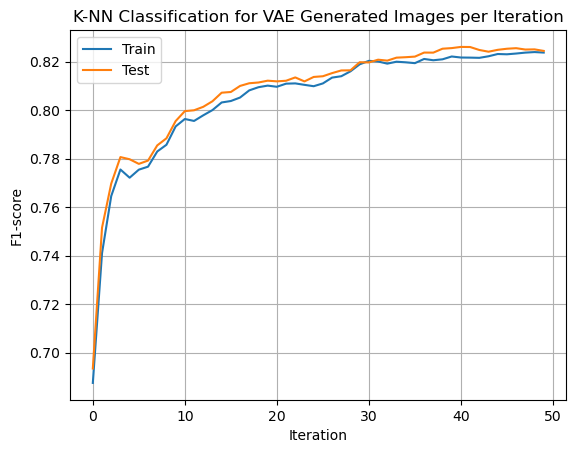

In [12]:
plt.plot(hist_clf_train_f1, label="Train")
plt.plot(hist_clf_test_f1, label="Test")

plt.xlabel("Iteration")
plt.ylabel("F1-score")
plt.title(f"K-NN Classification for VAE Generated Images per Iteration")
plt.legend()
plt.grid()
plt.show()

In [13]:
np.savez("history_generative_VAE.npz", hist_clf_train_f1=hist_clf_train_f1, hist_clf_test_f1=hist_clf_test_f1)

In [14]:
np.savez("VAE_Resconstructed_MNIST", x_train_classifier=x_train_classifier, y_train_classifier=y_train_classifier)